# Method 9 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

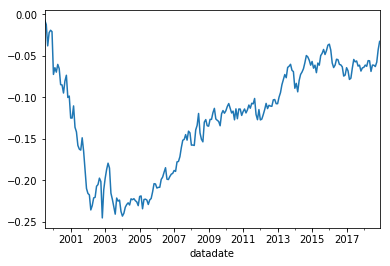

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.020936
2000-12-31   -0.079357
2001-12-31   -0.123556
2002-12-31   -0.001953
2003-12-31   -0.033100
2004-12-31    0.009127
2005-12-31    0.034013
2006-12-31    0.015991
2007-12-31    0.060400
2008-12-31    0.010013
2009-12-31    0.017453
2010-12-31   -0.003022
2011-12-31    0.008034
2012-12-31    0.008000
2013-12-31    0.043304
2014-12-31    0.008390
2015-12-31    0.025703
2016-12-31   -0.037453
2017-12-31    0.009362
2018-12-31    0.034079
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     18.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.44e-13
Time:                        20:36:07   Log-Likelihood:                 737.45
No. Observations:                 234   AIC:                            -1465.
Df Residuals:                     229   BIC:                            -1448.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.922e-06      0.001     -0.008      0.993      -0.001       0.001
mktrf         -0.0269      0.020     -1.380      0.169      -0.065       0.012
me            -0.0577      0.023     -2.543      0.012      -0.102      -0.013
ia            -0.1248      0.035     -3.617      0.000      -0.193      -0.057
roe            0.1429      0.030      4.839      0.000       0.085       0.201
==============================================================================
Omnibus:                       29.628   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.850
Skew:                          -0.580   Prob(JB):                     6.80e-16
Kurtosis:                       5.412   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     6.460
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.09e-05
Time:                        20:36:08   Log-Likelihood:                 737.45
No. Observations:                 234   AIC:                            -1465.
Df Residuals:                     229   BIC:                            -1448.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.922e-06      0.001     -0.007      0.994      -0.002       0.002
mktrf         -0.0269      0.020     -1.378      0.168      -0.065       0.011
me            -0.0577      0.029     -1.987      0.047      -0.115      -0.001
ia            -0.1248      0.059     -2.102      0.036      -0.241      -0.008
roe            0.1429      0.056      2.552      0.011       0.033       0.253
==============================================================================
Omnibus:                       29.628   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.850
Skew:                          -0.580   Prob(JB):                     6.80e-16
Kurtosis:                       5.412   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     6.188
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.58e-05
Time:                        20:36:08   Log-Likelihood:                 737.45
No. Observations:                 234   AIC:                            -1465.
Df Residuals:                     229   BIC:                            -1448.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.922e-06      0.001     -0.006      0.995      -0.002       0.002
mktrf         -0.0269      0.020     -1.374      0.170      -0.065       0.011
me            -0.0577      0.027     -2.102      0.036      -0.112      -0.004
ia            -0.1248      0.058     -2.149      0.032      -0.239      -0.011
roe            0.1429      0.058      2.469      0.014       0.029       0.256
==============================================================================
Omnibus:                       29.628   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.850
Skew:                          -0.580   Prob(JB):                     6.80e-16
Kurtosis:                       5.412   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     12.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.34e-10
Time:                        20:36:08   Log-Likelihood:                 732.34
No. Observations:                 234   AIC:                            -1453.
Df Residuals:                     228   BIC:                            -1432.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.693      0.489      -0.001       0.002
mktrf         -0.0620      0.020     -3.094      0.002      -0.101      -0.023
smb           -0.0734      0.026     -2.775      0.006      -0.125      -0.021
hml            0.0041      0.031      0.132      0.895      -0.057       0.066
rmw            0.0700      0.035      1.987      0.048       0.001       0.139
cma           -0.1352      0.045     -3.017      0.003      -0.223      -0.047
==============================================================================
Omnibus:                       35.578   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.909
Skew:                          -0.743   Prob(JB):                     5.42e-17
Kurtosis:                       5.339   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     8.573
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.85e-07
Time:                        20:36:08   Log-Likelihood:                 732.34
No. Observations:                 234   AIC:                            -1453.
Df Residuals:                     228   BIC:                            -1432.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.753      0.452      -0.001       0.002
mktrf         -0.0620      0.022     -2.756      0.006      -0.106      -0.018
smb           -0.0734      0.038     -1.929      0.054      -0.148       0.001
hml            0.0041      0.033      0.126      0.900      -0.060       0.068
rmw            0.0700      0.063      1.106      0.269      -0.054       0.194
cma           -0.1352      0.077     -1.750      0.080      -0.287       0.016
==============================================================================
Omnibus:                       35.578   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.909
Skew:                          -0.743   Prob(JB):                     5.42e-17
Kurtosis:                       5.339   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     10.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.46e-09
Time:                        20:36:08   Log-Likelihood:                 732.34
No. Observations:                 234   AIC:                            -1453.
Df Residuals:                     228   BIC:                            -1432.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.706      0.480      -0.001       0.002
mktrf         -0.0620      0.025     -2.462      0.014      -0.111      -0.013
smb           -0.0734      0.034     -2.179      0.029      -0.139      -0.007
hml            0.0041      0.027      0.153      0.879      -0.049       0.057
rmw            0.0700      0.067      1.040      0.298      -0.062       0.202
cma           -0.1352      0.079     -1.713      0.087      -0.290       0.020
==============================================================================
Omnibus:                       35.578   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.909
Skew:                          -0.743   Prob(JB):                     5.42e-17
Kurtosis:                       5.339   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     21.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.66e-15
Time:                        20:36:08   Log-Likelihood:                 741.39
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1456.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.69e-05      0.001      0.098      0.922      -0.001       0.001
mktrf         -0.0224      0.018     -1.265      0.207      -0.057       0.012
smb           -0.1335      0.022     -6.051      0.000      -0.177      -0.090
hml           -0.0297      0.022     -1.356      0.176      -0.073       0.013
umd            0.0815      0.014      5.668      0.000       0.053       0.110
==============================================================================
Omnibus:                       37.023   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.708
Skew:                          -0.513   Prob(JB):                     9.36e-35
Kurtosis:                       6.876   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     11.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.83e-08
Time:                        20:36:08   Log-Likelihood:                 741.39
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1456.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.69e-05      0.001      0.085      0.933      -0.001       0.002
mktrf         -0.0224      0.015     -1.476      0.140      -0.052       0.007
smb           -0.1335      0.022     -6.092      0.000      -0.176      -0.091
hml           -0.0297      0.023     -1.280      0.201      -0.075       0.016
umd            0.0815      0.030      2.682      0.007       0.022       0.141
==============================================================================
Omnibus:                       37.023   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.708
Skew:                          -0.513   Prob(JB):                     9.36e-35
Kurtosis:                       6.876   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     13.59
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.92e-10
Time:                        20:36:08   Log-Likelihood:                 741.39
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1456.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.69e-05      0.001      0.074      0.941      -0.002       0.002
mktrf         -0.0224      0.016     -1.393      0.164      -0.054       0.009
smb           -0.1335      0.019     -6.978      0.000      -0.171      -0.096
hml           -0.0297      0.021     -1.389      0.165      -0.072       0.012
umd            0.0815      0.029      2.826      0.005       0.025       0.138
==============================================================================
Omnibus:                       37.023   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.708
Skew:                          -0.513   Prob(JB):                     9.36e-35
Kurtosis:                       6.876   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     12.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.50e-08
Time:                        20:36:08   Log-Likelihood:                 357.28
No. Observations:                 120   AIC:                            -704.6
Df Residuals:                     115   BIC:                            -690.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.068      0.288      -0.004       0.001
mktrf         -0.0110      0.032     -0.339      0.735      -0.075       0.053
me            -0.0324      0.032     -1.012      0.314      -0.096       0.031
ia            -0.1705      0.050     -3.397      0.001      -0.270      -0.071
roe            0.2039      0.044      4.592      0.000       0.116       0.292
==============================================================================
Omnibus:                        9.512   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.607
Skew:                          -0.260   Prob(JB):                     0.000150
Kurtosis:                       4.803   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     3.625
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00806
Time:                        20:36:08   Log-Likelihood:                 357.28
No. Observations:                 120   AIC:                            -704.6
Df Residuals:                     115   BIC:                            -690.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.930      0.352      -0.004       0.001
mktrf         -0.0110      0.030     -0.368      0.713      -0.070       0.048
me            -0.0324      0.034     -0.946      0.344      -0.100       0.035
ia            -0.1705      0.079     -2.152      0.031      -0.326      -0.015
roe            0.2039      0.070      2.906      0.004       0.066       0.342
==============================================================================
Omnibus:                        9.512   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.607
Skew:                          -0.260   Prob(JB):                     0.000150
Kurtosis:                       4.803   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     3.540
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00920
Time:                        20:36:08   Log-Likelihood:                 357.28
No. Observations:                 120   AIC:                            -704.6
Df Residuals:                     115   BIC:                            -690.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.796      0.426      -0.004       0.002
mktrf         -0.0110      0.028     -0.394      0.693      -0.066       0.044
me            -0.0324      0.033     -0.996      0.319      -0.096       0.031
ia            -0.1705      0.074     -2.308      0.021      -0.315      -0.026
roe            0.2039      0.066      3.074      0.002       0.074       0.334
==============================================================================
Omnibus:                        9.512   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.607
Skew:                          -0.260   Prob(JB):                     0.000150
Kurtosis:                       4.803   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     7.132
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.73e-06
Time:                        20:36:08   Log-Likelihood:                 352.32
No. Observations:                 120   AIC:                            -692.6
Df Residuals:                     114   BIC:                            -675.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.537      0.592      -0.003       0.002
mktrf         -0.0808      0.036     -2.255      0.026      -0.152      -0.010
smb           -0.0517      0.041     -1.274      0.205      -0.132       0.029
hml            0.0006      0.050      0.011      0.991      -0.098       0.099
rmw            0.0951      0.059      1.622      0.108      -0.021       0.211
cma           -0.1788      0.064     -2.785      0.006      -0.306      -0.052
==============================================================================
Omnibus:                        9.616   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.133
Skew:                          -0.556   Prob(JB):                      0.00630
Kurtosis:                       3.888   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     4.352
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00116
Time:                        20:36:08   Log-Likelihood:                 352.32
No. Observations:                 120   AIC:                            -692.6
Df Residuals:                     114   BIC:                            -675.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.613      0.540      -0.003       0.002
mktrf         -0.0808      0.040     -1.998      0.046      -0.160      -0.002
smb           -0.0517      0.054     -0.958      0.338      -0.157       0.054
hml            0.0006      0.049      0.011      0.991      -0.096       0.097
rmw            0.0951      0.094      1.017      0.309      -0.088       0.278
cma           -0.1788      0.085     -2.104      0.035      -0.345      -0.012
==============================================================================
Omnibus:                        9.616   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.133
Skew:                          -0.556   Prob(JB):                      0.00630
Kurtosis:                       3.888   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     4.457
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000957
Time:                        20:36:08   Log-Likelihood:                 352.32
No. Observations:                 120   AIC:                            -692.6
Df Residuals:                     114   BIC:                            -675.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.548      0.584      -0.003       0.002
mktrf         -0.0808      0.045     -1.780      0.075      -0.170       0.008
smb           -0.0517      0.048     -1.066      0.287      -0.147       0.043
hml            0.0006      0.043      0.013      0.990      -0.084       0.085
rmw            0.0951      0.100      0.948      0.343      -0.101       0.292
cma           -0.1788      0.086     -2.076      0.038      -0.348      -0.010
==============================================================================
Omnibus:                        9.616   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.133
Skew:                          -0.556   Prob(JB):                      0.00630
Kurtosis:                       3.888   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     10.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.83e-07
Time:                        20:36:08   Log-Likelihood:                 354.31
No. Observations:                 120   AIC:                            -698.6
Df Residuals:                     115   BIC:                            -684.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.609      0.544      -0.003       0.002
mktrf         -0.0266      0.029     -0.907      0.366      -0.085       0.031
smb           -0.1392      0.033     -4.174      0.000      -0.205      -0.073
hml           -0.0397      0.033     -1.188      0.237      -0.106       0.027
umd            0.0812      0.021      3.942      0.000       0.040       0.122
==============================================================================
Omnibus:                       12.545   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.824
Skew:                          -0.288   Prob(JB):                     3.34e-07
Kurtosis:                       5.373   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     5.985
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000207
Time:                        20:36:08   Log-Likelihood:                 354.31
No. Observations:                 120   AIC:                            -698.6
Df Residuals:                     115   BIC:                            -684.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.562      0.574      -0.003       0.002
mktrf         -0.0266      0.024     -1.111      0.267      -0.073       0.020
smb           -0.1392      0.033     -4.205      0.000      -0.204      -0.074
hml           -0.0397      0.033     -1.217      0.224      -0.104       0.024
umd            0.0812      0.036      2.231      0.026       0.010       0.153
==============================================================================
Omnibus:                       12.545   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.824
Skew:                          -0.288   Prob(JB):                     3.34e-07
Kurtosis:                       5.373   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     7.959
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-05
Time:                        20:36:08   Log-Likelihood:                 354.31
No. Observations:                 120   AIC:                            -698.6
Df Residuals:                     115   BIC:                            -684.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.477      0.633      -0.004       0.002
mktrf         -0.0266      0.027     -1.001      0.317      -0.079       0.025
smb           -0.1392      0.029     -4.868      0.000      -0.195      -0.083
hml           -0.0397      0.029     -1.371      0.170      -0.096       0.017
umd            0.0812      0.034      2.412      0.016       0.015       0.147
==============================================================================
Omnibus:                       12.545   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.824
Skew:                          -0.288   Prob(JB):                     3.34e-07
Kurtosis:                       5.373   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     8.009
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.07e-05
Time:                        20:36:08   Log-Likelihood:                 405.01
No. Observations:                 114   AIC:                            -800.0
Df Residuals:                     109   BIC:                            -786.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.981      0.050    -7.9e-07       0.003
mktrf         -0.0400      0.021     -1.921      0.057      -0.081       0.001
me            -0.1088      0.032     -3.382      0.001      -0.173      -0.045
ia            -0.0442      0.045     -0.990      0.324      -0.133       0.044
roe            0.0144      0.039      0.368      0.713      -0.063       0.092
==============================================================================
Omnibus:                        3.557   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.001
Skew:                          -0.377   Prob(JB):                        0.223
Kurtosis:                       3.251   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     28.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.72e-16
Time:                        20:36:08   Log-Likelihood:                 405.01
No. Observations:                 114   AIC:                            -800.0
Df Residuals:                     109   BIC:                            -786.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.399      0.016       0.000       0.003
mktrf         -0.0400      0.020     -2.008      0.045      -0.079      -0.001
me            -0.1088      0.032     -3.355      0.001      -0.172      -0.045
ia            -0.0442      0.042     -1.063      0.288      -0.126       0.037
roe            0.0144      0.038      0.382      0.702      -0.060       0.089
==============================================================================
Omnibus:                        3.557   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.001
Skew:                          -0.377   Prob(JB):                        0.223
Kurtosis:                       3.251   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     42.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.11e-21
Time:                        20:36:08   Log-Likelihood:                 405.01
No. Observations:                 114   AIC:                            -800.0
Df Residuals:                     109   BIC:                            -786.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.636      0.008       0.000       0.002
mktrf         -0.0400      0.019     -2.111      0.035      -0.077      -0.003
me            -0.1088      0.033     -3.301      0.001      -0.173      -0.044
ia            -0.0442      0.044     -0.998      0.318      -0.131       0.043
roe            0.0144      0.037      0.393      0.694      -0.058       0.086
==============================================================================
Omnibus:                        3.557   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.001
Skew:                          -0.377   Prob(JB):                        0.223
Kurtosis:                       3.251   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     6.300
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.61e-05
Time:                        20:36:08   Log-Likelihood:                 404.91
No. Observations:                 114   AIC:                            -797.8
Df Residuals:                     108   BIC:                            -781.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.039      0.044    4.06e-05       0.003
mktrf         -0.0445      0.020     -2.224      0.028      -0.084      -0.005
smb           -0.1078      0.032     -3.323      0.001      -0.172      -0.044
hml           -0.0286      0.041     -0.692      0.490      -0.111       0.053
rmw           -0.0090      0.051     -0.177      0.860      -0.109       0.091
cma           -0.0087      0.064     -0.136      0.892      -0.136       0.119
==============================================================================
Omnibus:                        5.869   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.297
Skew:                          -0.473   Prob(JB):                       0.0708
Kurtosis:                       3.469   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     27.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.42e-18
Time:                        20:36:08   Log-Likelihood:                 404.91
No. Observations:                 114   AIC:                            -797.8
Df Residuals:                     108   BIC:                            -781.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.428      0.015       0.000       0.003
mktrf         -0.0445      0.021     -2.100      0.036      -0.086      -0.003
smb           -0.1078      0.018     -6.086      0.000      -0.143      -0.073
hml           -0.0286      0.039     -0.737      0.461      -0.105       0.048
rmw           -0.0090      0.066     -0.136      0.892      -0.138       0.120
cma           -0.0087      0.057     -0.153      0.878      -0.121       0.103
==============================================================================
Omnibus:                        5.869   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.297
Skew:                          -0.473   Prob(JB):                       0.0708
Kurtosis:                       3.469   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     38.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.00e-22
Time:                        20:36:08   Log-Likelihood:                 404.91
No. Observations:                 114   AIC:                            -797.8
Df Residuals:                     108   BIC:                            -781.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      2.939      0.003       0.000       0.002
mktrf         -0.0445      0.020     -2.201      0.028      -0.084      -0.005
smb           -0.1078      0.018     -5.986      0.000      -0.143      -0.073
hml           -0.0286      0.039     -0.726      0.468      -0.106       0.049
rmw           -0.0090      0.064     -0.140      0.889      -0.135       0.117
cma           -0.0087      0.053     -0.166      0.868      -0.112       0.095
==============================================================================
Omnibus:                        5.869   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.297
Skew:                          -0.473   Prob(JB):                       0.0708
Kurtosis:                       3.469   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     12.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.36e-08
Time:                        20:36:08   Log-Likelihood:                 412.32
No. Observations:                 114   AIC:                            -814.6
Df Residuals:                     109   BIC:                            -801.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.626      0.107      -0.000       0.002
mktrf         -0.0319      0.019     -1.720      0.088      -0.069       0.005
smb           -0.1128      0.029     -3.904      0.000      -0.170      -0.056
hml            0.0021      0.030      0.070      0.944      -0.057       0.061
umd            0.0886      0.022      3.950      0.000       0.044       0.133
==============================================================================
Omnibus:                        3.579   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.049
Skew:                          -0.291   Prob(JB):                        0.218
Kurtosis:                       3.550   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     36.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.23e-19
Time:                        20:36:08   Log-Likelihood:                 412.32
No. Observations:                 114   AIC:                            -814.6
Df Residuals:                     109   BIC:                            -801.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.920      0.055   -2.24e-05       0.002
mktrf         -0.0319      0.014     -2.289      0.022      -0.059      -0.005
smb           -0.1128      0.027     -4.206      0.000      -0.165      -0.060
hml            0.0021      0.025      0.083      0.934      -0.047       0.051
umd            0.0886      0.017      5.364      0.000       0.056       0.121
==============================================================================
Omnibus:                        3.579   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.049
Skew:                          -0.291   Prob(JB):                        0.218
Kurtosis:                       3.550   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     36.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.55e-19
Time:                        20:36:08   Log-Likelihood:                 412.32
No. Observations:                 114   AIC:                            -814.6
Df Residuals:                     109   BIC:                            -801.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      2.082      0.037     6.3e-05       0.002
mktrf         -0.0319      0.012     -2.747      0.006      -0.055      -0.009
smb           -0.1128      0.030     -3.727      0.000      -0.172      -0.053
hml            0.0021      0.025      0.083      0.934      -0.047       0.051
umd            0.0886      0.017      5.283      0.000       0.056       0.122
==============================================================================
Omnibus:                        3.579   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.049
Skew:                          -0.291   Prob(JB):                        0.218
Kurtosis:                       3.550   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""